In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

2025-07-15 03:09:54.607397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752548994.803044      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752548994.862301      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_dir = '/kaggle/input/newaslsinhala/datasetSinha/train'  
val_dir = '/kaggle/input/newaslsinhala/datasetSinha/test'      
image_size = (224, 224)
batch_size = 32
epochs = 10
k_folds = 5

In [3]:
def load_image_paths(directory):
    classes = sorted(os.listdir(directory))
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    
    image_paths = []
    labels = []
    
    for cls_name in classes:
        cls_dir = os.path.join(directory, cls_name)
        for img_name in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img_name)
            image_paths.append(img_path)
            labels.append(class_to_idx[cls_name])
    
    return np.array(image_paths), np.array(labels), classes

In [4]:
train_paths, train_labels, class_names = load_image_paths(train_dir)
val_paths, val_labels, _ = load_image_paths(val_dir)
num_classes = len(class_names)

In [5]:
def create_model():
    base_model = tf.keras.applications.DenseNet121(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    x = base_model.output
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(base_model.input, outputs)
    
    # Freeze base layers
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [6]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size, img_size, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_paths = self.image_paths[index*self.batch_size:(index+1)*self.batch_size]
        batch_labels = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        
        batch_images = []
        for path in batch_paths:
            img = Image.open(path).convert('RGB')
            img = img.resize(self.img_size)
            img = np.array(img) / 255.0
            batch_images.append(img)
            
        return np.array(batch_images), np.array(batch_labels)
    
    def on_epoch_end(self):
        if self.shuffle:
            shuffled_indices = np.random.permutation(len(self.image_paths))
            self.image_paths = self.image_paths[shuffled_indices]
            self.labels = self.labels[shuffled_indices]

In [7]:
all_paths = np.concatenate([train_paths, val_paths])
all_labels = np.concatenate([train_labels, val_labels])

kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_history = []
all_reports = []
for fold, (train_idx, val_idx) in enumerate(kf.split(all_paths)):
    print(f"\n========== Fold {fold + 1}/{k_folds} ==========")
    
    
    train_gen = CustomDataGenerator(
        all_paths[train_idx], all_labels[train_idx],
        batch_size=batch_size, img_size=image_size, shuffle=True
    )
    
    val_gen = CustomDataGenerator(
        all_paths[val_idx], all_labels[val_idx],
        batch_size=batch_size, img_size=image_size, shuffle=False
    )
    
  
    model = create_model()
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        verbose=1
    )
    fold_history.append(history.history)
    
   
    y_true = val_gen.labels
    y_pred = np.argmax(model.predict(val_gen), axis=1)


========== Fold 1/5 ==========


I0000 00:00:1752549010.575604      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752549010.576464      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1752549036.411070      97 service.cc:148] XLA service 0x7eec84003680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752549036.411961      97 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752549036.411977      97 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752549039.526100      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/459 ━━━━━━━━━━━━━━━━━━━━ 4:33:16 36s/step - accuracy: 0.0312 - loss: 3.9054

I0000 00:00:1752549051.521639      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


459/459 ━━━━━━━━━━━━━━━━━━━━ 395s 784ms/step - accuracy: 0.7218 - loss: 1.1139 - val_accuracy: 0.9842 - val_loss: 0.0780
Epoch 2/10
459/459 ━━━━━━━━━━━━━━━━━━━━ 156s 339ms/step - accuracy: 0.9773 - loss: 0.0857 - val_accuracy: 0.9858 - val_loss: 0.0560
Epoch 3/10
459/459 ━━━━━━━━━━━━━━━━━━━━ 157s 343ms/step - accuracy: 0.9864 - loss: 0.0504 - val_accuracy: 0.9823 - val_loss: 0.0580
Epoch 4/10
459/459 ━━━━━━━━━━━━━━━━━━━━ 155s 339ms/step - accuracy: 0.9904 - loss: 0.0352 - val_accuracy: 0.9888 - val_loss: 0.0435
Epoch 5/10
459/459 ━━━━━━━━━━━━━━━━━━━━ 159s 346ms/step - accuracy: 0.9888 - loss: 0.0348 - val_accuracy: 0.9896 - val_loss: 0.0332
Epoch 6/10
459/459 ━━━━━━━━━━━━━━━━━━━━ 158s 344ms/step - accuracy: 0.9875 - loss: 0.0402 - val_accuracy: 0.9899 - val_loss: 0.0323
Epoch 7/10
459/459 ━━━━━━━━━━━━━━━━━━━━ 157s 343ms/step - accuracy: 0.9861 - loss: 0.0392 - val_accuracy: 0.9820 - val_loss: 0.0525
Epoch 8/10
459/459 ━━━━━━━━━━━━━━━━━━━━ 156s 341ms/step - accuracy: 0.9871 - loss: 0.03


Classification Report:
                   precision    recall  f1-score   support

            eight       1.00      0.98      0.99       125
         eleven_2       1.00      0.99      0.99        96
         eleven_3       1.00      1.00      1.00       125
          fifty_1       1.00      0.99      0.99        93
          fifty_2       0.99      1.00      0.99        90
          fifty_3       0.99      0.99      0.99        89
             five       1.00      0.95      0.98       103
   fourfourteen_2       0.90      0.99      0.94       140
       fourteen_1       0.98      1.00      0.99        57
       fourteen_3       0.99      1.00      0.99        71
             nine       1.00      1.00      1.00        41
one&ten_2eleven_1       0.99      0.95      0.97       131
            seven       1.00      1.00      1.00       137
              six       0.99      1.00      0.99       204
            ten_1       1.00      0.99      0.99       163
            ten_3       0.99   

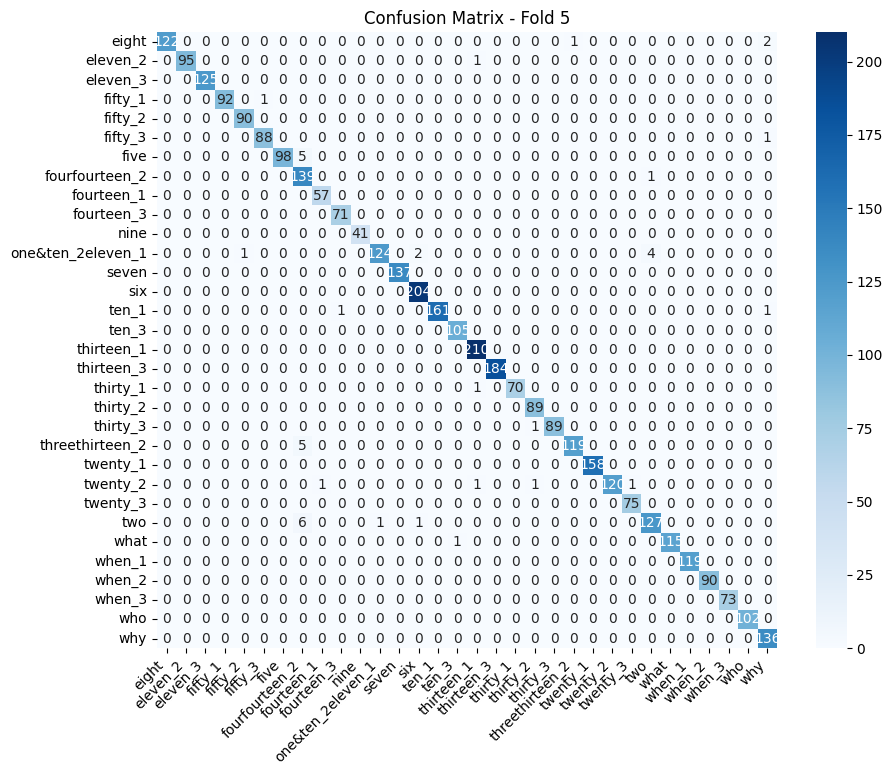

In [14]:
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:")
print(report)
all_reports.append(report)
    
    # Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - Fold {fold + 1}')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

115/115 ━━━━━━━━━━━━━━━━━━━━ 28s 241ms/step


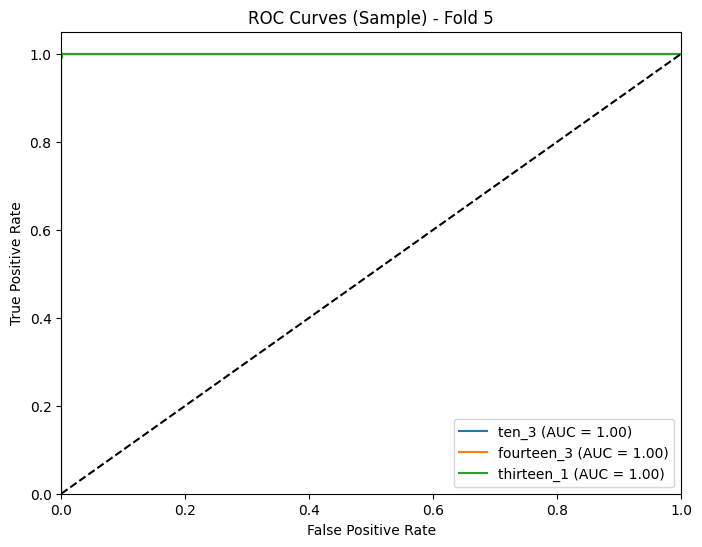

In [17]:
sample_classes = np.random.choice(num_classes, size=min(3, num_classes), replace=False)
y_prob = model.predict(val_gen)
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    
plt.figure(figsize=(8, 6))
for i in sample_classes:
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves (Sample) - Fold {fold + 1}')
plt.legend(loc="lower right")
plt.show()

In [19]:
print("\nTraining final model on all data...")
full_train_gen = CustomDataGenerator(all_paths, all_labels, batch_size, image_size)
final_model = create_model()
final_model.fit(full_train_gen, epochs=epochs)
# Save final model
final_model.save('/kaggle/working/final_model_trained_on_all_datadensenet121.h5')
print("Final model saved as 'final_model_trained_on_all_data.h5'")


Training final model on all data...
Epoch 1/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 179s 265ms/step - accuracy: 0.7399 - loss: 1.0063
Epoch 2/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 146s 255ms/step - accuracy: 0.9788 - loss: 0.0781
Epoch 3/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 145s 253ms/step - accuracy: 0.9857 - loss: 0.0502
Epoch 4/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 146s 254ms/step - accuracy: 0.9871 - loss: 0.0429
Epoch 5/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 144s 251ms/step - accuracy: 0.9852 - loss: 0.0535
Epoch 6/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 142s 248ms/step - accuracy: 0.9850 - loss: 0.0471
Epoch 7/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 146s 254ms/step - accuracy: 0.9894 - loss: 0.0321
Epoch 8/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 143s 250ms/step - accuracy: 0.9876 - loss: 0.0403
Epoch 9/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 144s 251ms/step - accuracy: 0.9917 - loss: 0.0276
Epoch 10/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 146s 255ms/step - accuracy: 0.9899 - loss: 0.0335
Final model saved as 'final_model_trained_on_all_data.h5'


In [20]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()


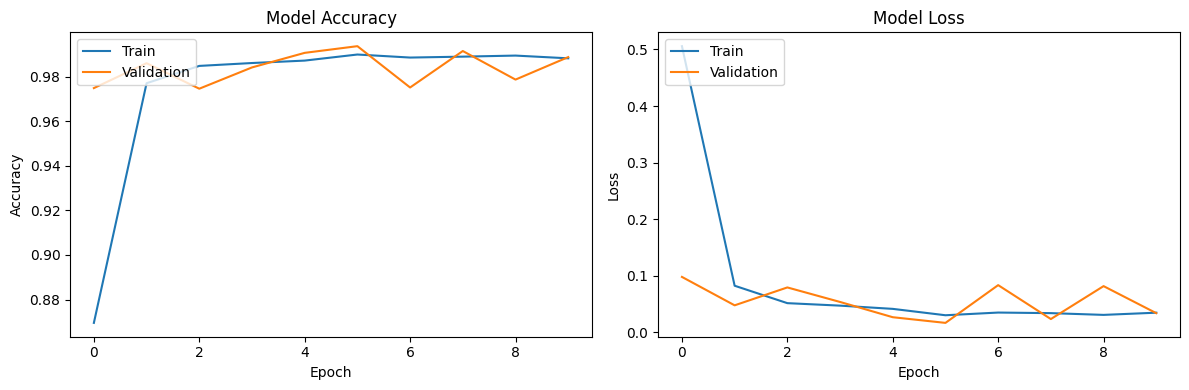

In [21]:
plot_training_history(fold_history[-1])

In [23]:
print("\n=== Classification Reports for All Folds ===")
for i, report in enumerate(all_reports, 1):
    print(f"\nFold {i}:\n{report}")


=== Classification Reports for All Folds ===

Fold 1:
                   precision    recall  f1-score   support

            eight       1.00      0.98      0.99       125
         eleven_2       1.00      0.99      0.99        96
         eleven_3       1.00      1.00      1.00       125
          fifty_1       1.00      0.99      0.99        93
          fifty_2       0.99      1.00      0.99        90
          fifty_3       0.99      0.99      0.99        89
             five       1.00      0.95      0.98       103
   fourfourteen_2       0.90      0.99      0.94       140
       fourteen_1       0.98      1.00      0.99        57
       fourteen_3       0.99      1.00      0.99        71
             nine       1.00      1.00      1.00        41
one&ten_2eleven_1       0.99      0.95      0.97       131
            seven       1.00      1.00      1.00       137
              six       0.99      1.00      0.99       204
            ten_1       1.00      0.99      0.99       163


115/115 ━━━━━━━━━━━━━━━━━━━━ 29s 251ms/step


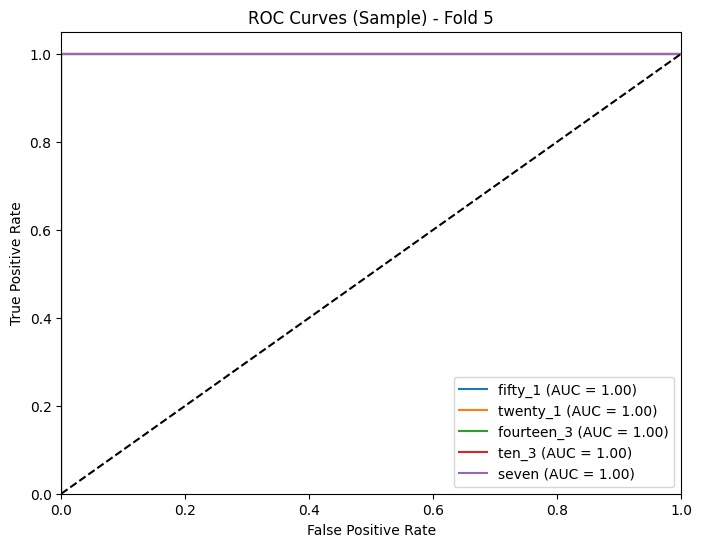

In [25]:
sample_classes = np.random.choice(num_classes, size=min(5, num_classes), replace=False)
y_prob = model.predict(val_gen)
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    
plt.figure(figsize=(8, 6))
for i in sample_classes:
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves (Sample) - Fold {fold + 1}')
plt.legend(loc="lower right")
plt.show()

115/115 ━━━━━━━━━━━━━━━━━━━━ 28s 241ms/step


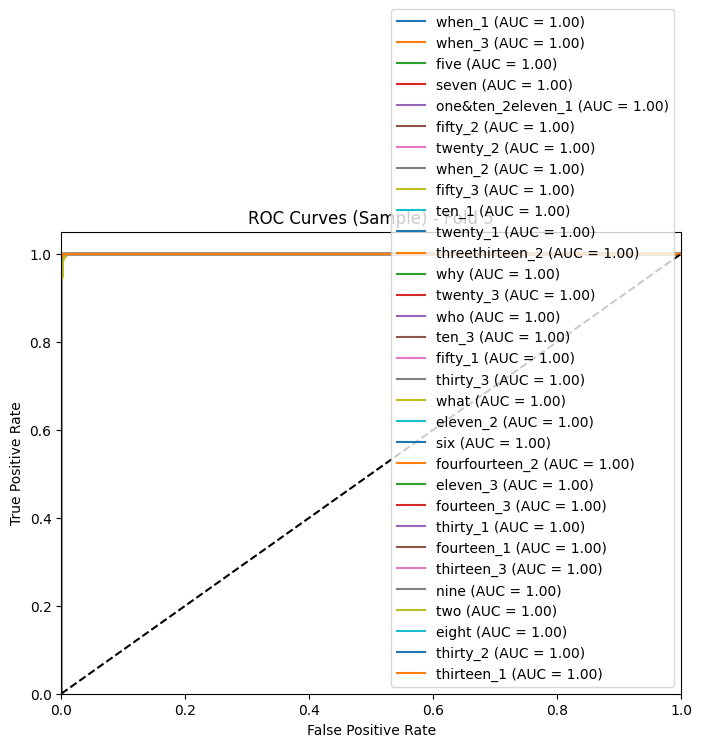

In [26]:
sample_classes = np.random.choice(num_classes, size=min(32, num_classes), replace=False)
y_prob = model.predict(val_gen)
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    
plt.figure(figsize=(8, 6))
for i in sample_classes:
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves (Sample) - Fold {fold + 1}')
plt.legend(loc="lower right")
plt.show()